# Visualize tip data from model data frames

In [1]:
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
# Read model data frame.
df = pd.read_table("../../model_data_frames/2016-2018/1/ep/0.tsv")

In [3]:
df.head()

,clade_name,frequency,name,predictor:ep,timepoint
0,NODE_0000181,0.145351,A/Bangladesh/1010/2017,-0.915997,2017.33
1,NODE_0000181,0.000000,A/SouthAustralia/131/2017,-0.137518,2017.33
2,NODE_0000181,0.000000,A/SouthAustralia/209/2017,-0.137518,2017.33
3,NODE_0000179,0.145351,A/Bangladesh/1010/2017,-0.915997,2017.33
4,NODE_0000179,0.083148,A/Qatar/10-VI-17-0020012/2017,-0.915997,2017.33


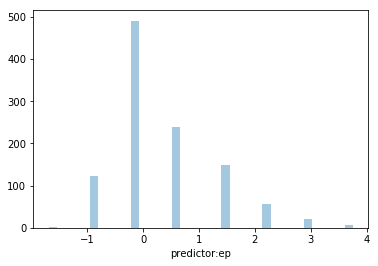

In [4]:
sns.distplot(df["predictor:ep"], kde=False)